## 📊 Analisis FIES Aceh 2022 - Laporan Data Mining

### 📘 Deskripsi Project

` - Food Insecurity Experience Scale (FIES) adalah instrumen untuk mengukur kerawanan pangan rumah tangga. Dalam project ini, dilakukan analisis data FIES Aceh tahun 2022 menggunakan Python dengan fokus pada klasifikasi status kerawanan pangan. `

`- Installastion Library`

In [845]:
# !pip install pandas numpy matplotlib seaborn scikit-learn
# !pip install imbalanced-learn

`Import Library`

In [846]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import auc, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

`Set Style Visualisic`

In [847]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Config Warna Visual
colors = ['#2ecc71',"#e74c3c", '#3498db','#f39c12' ]


`Load Dataset`

In [848]:
df = pd.read_csv('./data/FIES_Aceh2022_999.csv')

###  Task 1 - STATISTIK DESKRIPTIF & VISUALISASI

` 1.1 Hitung jumlah & Persentase Status_Rawan`

In [849]:

status_counts = df['Status_Rawan'].value_counts()
status_percentage = df['Status_Rawan'].value_counts(normalize=True) * 100

print("\n📈 DISTRIBUSI STATUS RAWAN PANGAN")
print("-" * 40)
print(f"✅ Tidak Rawan: {status_counts['Tidak Rawan']} rumah tangga ({status_percentage['Tidak Rawan']:.1f}%)")
print(f"⚠️  Rawan: {status_counts['Rawan']} rumah tangga ({status_percentage['Rawan']:.1f}%)")
print(f"📊 Total: {len(df)} rumah tangga")


📈 DISTRIBUSI STATUS RAWAN PANGAN
----------------------------------------
✅ Tidak Rawan: 789 rumah tangga (79.0%)
⚠️  Rawan: 210 rumah tangga (21.0%)
📊 Total: 999 rumah tangga


` 1.2 Visualisasi Distribusi Status Kerentanan - BAR CHART, PIE, DONUT`

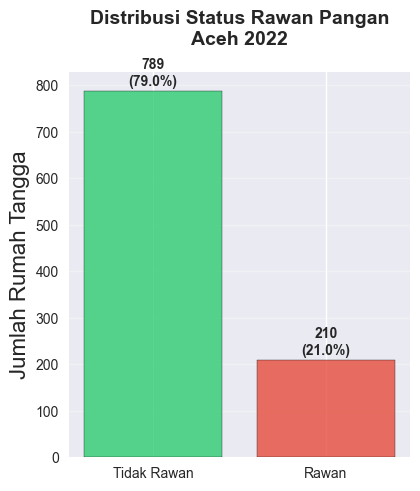

In [850]:
plt.figure(figsize=(15, 5))

# Bar Chart
plt.subplot(1, 3, 1)
bars = plt.bar(status_counts.index, status_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Distribusi Status Rawan Pangan\nAceh 2022', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Jumlah Rumah Tangga', fontsize=16)
plt.xticks( fontsize=10)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height}\n({height/len(df)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)


`1.3 Interpretasikan hasilnya`

In [851]:
# 📖 Interpretasi Statistik Deskriptif
total = len(df)
rawan = status_counts[1] if 1 in status_counts.index else status_counts.get("Rawan", 0)
tdk_rawan = status_counts[0] if 0 in status_counts.index else status_counts.get("Tidak Rawan", 0)
persen_rawan = status_percentage[1] if 1 in status_percentage.index else status_percentage.get("Rawan", 0)
persen_tdk_rawan = status_percentage[0] if 0 in status_percentage.index else status_percentage.get("Tidak Rawan", 0) 

print("📖 INTERPRETASI HASIL:")
print(f"Dari total {total} rumah tangga responden di Aceh tahun 2022, "
      f"sebanyak {rawan} rumah tangga ({persen_rawan:.1f}%) dikategorikan *Rawan Pangan*, "
      f"sementara {tdk_rawan} rumah tangga ({persen_tdk_rawan:.1f}%) tergolong *Tidak Rawan*.")

if persen_rawan > persen_tdk_rawan:
    print("➡️ Artinya, mayoritas rumah tangga mengalami kondisi rawan pangan. "
          "Hal ini menunjukkan masih rendahnya ketahanan pangan di wilayah tersebut.")
else:
    print("✅ Sebagian besar rumah tangga tergolong tidak rawan pangan, "
          "namun kelompok rawan tetap perlu mendapat perhatian khusus dalam intervensi kebijakan.")

print("\nKesimpulan: Analisis deskriptif ini menjadi dasar untuk model klasifikasi pada Task 2, "
      "agar dapat mengidentifikasi faktor-faktor yang paling berpengaruh terhadap status kerawanan pangan.")

📖 INTERPRETASI HASIL:
Dari total 999 rumah tangga responden di Aceh tahun 2022, sebanyak 210 rumah tangga (21.0%) dikategorikan *Rawan Pangan*, sementara 789 rumah tangga (79.0%) tergolong *Tidak Rawan*.
✅ Sebagian besar rumah tangga tergolong tidak rawan pangan, namun kelompok rawan tetap perlu mendapat perhatian khusus dalam intervensi kebijakan.

Kesimpulan: Analisis deskriptif ini menjadi dasar untuk model klasifikasi pada Task 2, agar dapat mengidentifikasi faktor-faktor yang paling berpengaruh terhadap status kerawanan pangan.


###  Task 2 - PEMODELAN KLASIFIKASI

`2.1 Split Data`

In [852]:
# Encode variabel kategorikal
le = LabelEncoder()
df_encoded = df.copy()

# Encode target variable
df_encoded['Status_Rawan'] = le.fit_transform(df['Status_Rawan'])
# 0 = Tidak Rawan, 1 = Rawan

# Encode variabel kategorikal lainnya
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'Status_Rawan':
        df_encoded[col] = le.fit_transform(df[col].astype(str))

# Pisahkan features dan target
X = df_encoded.drop('Status_Rawan', axis=1)
y = df_encoded['Status_Rawan']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardisasi data untuk KNN dan SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Preprocessing selesai!")
print(f"📊 Data Training: {X_train.shape[0]} sampel")
print(f"📊 Data Testing: {X_test.shape[0]} sampel")
print(f"🎯 Jumlah Fitur: {X_train.shape[1]}")

✅ Preprocessing selesai!
📊 Data Training: 699 sampel
📊 Data Testing: 300 sampel
🎯 Jumlah Fitur: 34


` 2.2 Training 4 Classifier `

In [853]:
models = {
    'k-Nearest Neighbour': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}
result = {}

In [854]:
for name, model in models.items():
    print(f" Training {name}...")
    
    # Gunakan data scaled untuk KNN dan SVM
    if name in ['k-Nearest Neighbour', 'Support Vector Machine']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test
    
    # Training
    model.fit(X_train_used, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test_used)
    y_prob = model.predict_proba(X_test_used)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_used)
    
    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train_used, y_train, cv=5, scoring='accuracy')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    result[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_prob': y_prob,
        'cm': cm
    }
    
    print(f" {name} selesai - Accuracy: {accuracy:.3f}")

 Training k-Nearest Neighbour...
 k-Nearest Neighbour selesai - Accuracy: 0.750
 Training Naive Bayes...
 Naive Bayes selesai - Accuracy: 0.300
 Training Decision Tree...
 Decision Tree selesai - Accuracy: 0.763
 Training Support Vector Machine...
 Support Vector Machine selesai - Accuracy: 0.790


`2.3 Evaluasi dengan Accuracy, Precision, Recall, F1, ROC-AUC`

In [855]:
eval_df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': result[name]['accuracy'],
        'Precision': result[name]['precision'],
        'Recall': result[name]['recall'],
        'F1-Score': result[name]['f1'],
        'ROC-AUC': result[name]['auc'],
        'CV Mean': result[name]['cv_mean'],
        'CV Std': result[name]['cv_std']
    }
    for name in result.keys()
])

eval_df = eval_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Tampilkan tabel hasil evaluasi
print("📊 Hasil Evaluasi Model:")
print(eval_df)

📊 Hasil Evaluasi Model:
                    Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0  Support Vector Machine  0.790000   0.790000  1.000000  0.882682  0.645570   
1           Decision Tree  0.763333   0.790210  0.953586  0.864245  0.526321   
2     k-Nearest Neighbour  0.750000   0.791367  0.928270  0.854369  0.631036   
3             Naive Bayes  0.300000   0.800000  0.151899  0.255319  0.615029   

    CV Mean    CV Std  
0  0.789702  0.003301  
1  0.751048  0.018634  
2  0.762487  0.018156  
3  0.329003  0.031242  


In [856]:
print("🔍 DETAIL EVALUASI SETIAP MODEL - CONFUSION MATRIX ANALYSIS")

for name, metrics_dict in result.items():
    cm = metrics_dict['cm']
    tn, fp, fn, tp = cm.ravel()
    
    # Hitung tambahan metrik
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Hitung persentase tiap sel
    total = tn + fp + fn + tp
    tn_pct = (tn / total) * 100
    fp_pct = (fp / total) * 100
    fn_pct = (fn / total) * 100
    tp_pct = (tp / total) * 100

    print(f"\n📊 {name}:")
    print("-" * 60)

    # ==== CONFUSION MATRIX VISUAL ====
    print(f"\n📋 CONFUSION MATRIX (Actual vs Predicted):")
    print(f"         Predicted 0   Predicted 1")
    print(f"         (Tdk Rawan)   (Rawan)")
    print(f"        ┌─────────────┬─────────────┐")
    print(f"Actual 0│   TN: {tn:<5d}     │   FP: {fp:<5d}     │ ← Specificity: {specificity:.3f}")
    print(f"(Tdk R) │  ({tn_pct:5.1f}%)   │  ({fp_pct:5.1f}%)   │")
    print(f"        ├─────────────┼─────────────┤")
    print(f"Actual 1│   FN: {fn:<5d}     │   TP: {tp:<5d}     │ ← Recall: {metrics_dict['recall']:.3f}")
    print(f"(Rawan) │  ({fn_pct:5.1f}%)   │  ({tp_pct:5.1f}%)   │")
    print(f"        └─────────────┴─────────────┘")


🔍 DETAIL EVALUASI SETIAP MODEL - CONFUSION MATRIX ANALYSIS

📊 k-Nearest Neighbour:
------------------------------------------------------------

📋 CONFUSION MATRIX (Actual vs Predicted):
         Predicted 0   Predicted 1
         (Tdk Rawan)   (Rawan)
        ┌─────────────┬─────────────┐
Actual 0│   TN: 5         │   FP: 58        │ ← Specificity: 0.079
(Tdk R) │  (  1.7%)   │  ( 19.3%)   │
        ├─────────────┼─────────────┤
Actual 1│   FN: 17        │   TP: 220       │ ← Recall: 0.928
(Rawan) │  (  5.7%)   │  ( 73.3%)   │
        └─────────────┴─────────────┘

📊 Naive Bayes:
------------------------------------------------------------

📋 CONFUSION MATRIX (Actual vs Predicted):
         Predicted 0   Predicted 1
         (Tdk Rawan)   (Rawan)
        ┌─────────────┬─────────────┐
Actual 0│   TN: 54        │   FP: 9         │ ← Specificity: 0.857
(Tdk R) │  ( 18.0%)   │  (  3.0%)   │
        ├─────────────┼─────────────┤
Actual 1│   FN: 201       │   TP: 36        │ ← Recall: 0.152

`2.4 VISUALISASIKAN ROC CURVE`

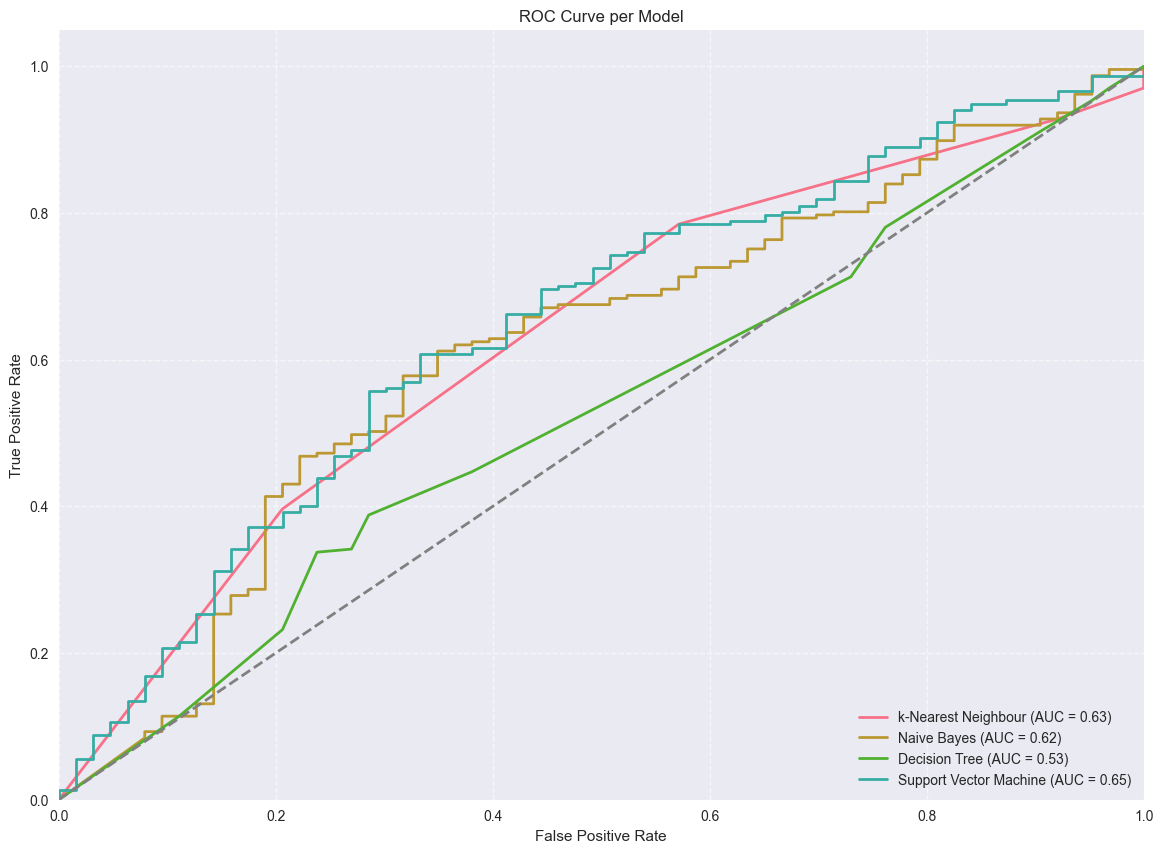

In [857]:
# OverWrite
from sklearn.metrics import auc, roc_curve
# Initial Canvas
plt.figure(figsize=(14, 10))

for name, data in result.items():
    fpr, tpr, _ = roc_curve(y_test, data['y_prob'])
    roc_auc_value = auc(fpr, tpr)  
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_value:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Model')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

`2.5 TENTUKAN MODEL TERBAIK`

In [ ]:
# dataframe dari hasil evaluasi
evaluation_summary = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['auc'],
        'CV Mean': metrics['cv_mean']
    }
    for name, metrics in result.items()
])

# Urutkan berdasarkan ROC-AUC
evaluation_summary = evaluation_summary.sort_values(
    by=['ROC-AUC', 'F1-Score', 'Accuracy'],
    ascending=False
).reset_index(drop=True)

# Model terbaik
best_model_name = evaluation_summary.loc[0, 'Model']
best_metrics = evaluation_summary.loc[0]

print("\n🏆 MODEL TERBAIK BERDASARKAN HASIL EVALUASI")
print(f"📈 Model: {best_model_name}")
print(f"   • Accuracy : {best_metrics['Accuracy']:.3f}")
print(f"   • Precision: {best_metrics['Precision']:.3f}")
print(f"   • Recall   : {best_metrics['Recall']:.3f}")
print(f"   • F1-Score : {best_metrics['F1-Score']:.3f}")
print(f"   • ROC-AUC  : {best_metrics['ROC-AUC']:.3f}")
print(f"   • CV Mean  : {best_metrics['CV Mean']:.3f}")

print("\n📊 Ringkasan Evaluasi Semua Model:")
print(evaluation_summary)


🏆 MODEL TERBAIK BERDASARKAN HASIL EVALUASI
------------------------------------------------------------
📈 Model: Support Vector Machine
   • Accuracy : 0.790
   • Precision: 0.790
   • Recall   : 1.000
   • F1-Score : 0.883
   • ROC-AUC  : 0.646
   • CV Mean  : 0.790

📊 Ringkasan Evaluasi Semua Model:
                    Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0  Support Vector Machine  0.790000   0.790000  1.000000  0.882682  0.645570   
1     k-Nearest Neighbour  0.750000   0.791367  0.928270  0.854369  0.631036   
2             Naive Bayes  0.300000   0.800000  0.151899  0.255319  0.615029   
3           Decision Tree  0.763333   0.790210  0.953586  0.864245  0.526321   

    CV Mean  
0  0.789702  
1  0.762487  
2  0.329003  
3  0.751048  


###  Task 3 - Rekomendasi Kebijakan

`3.1 Berdasarkan hasil analisis, berikan rekomendasi intervensi (maks. 3 indikator prioritas).`

In [859]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

perm = permutation_importance(rf_model, X_test, y_test, n_repeats=20, random_state=42)
feat_imp = pd.DataFrame({
    'feature': X_test.columns if hasattr(X_test, 'columns') else [f'X{i}' for i in range(X_test.shape[1])],
    'importance': perm.importances_mean
}).sort_values('importance', ascending=False)

print("📊 10 Fitur dengan Importance Tertinggi:")
print(feat_imp.head(10))


📊 10 Fitur dengan Importance Tertinggi:
              feature  importance
24           Umur_KRT    0.006333
20   Sumber_Air_Minum    0.005500
19  Bahan_Bakar_Masak    0.004000
0      Pendidikan_KRT    0.003667
10               BPJS    0.003333
11           Jamkesda    0.003167
7                 KKS    0.003167
28         Buta_Huruf    0.003000
27             ART014    0.002500
9       Bantuan_Pemda    0.001833


In [860]:
top_features = feat_imp.head(3)
print("🔝 3 Indikator Prioritas untuk Intervensi:")
print(top_features)

🔝 3 Indikator Prioritas untuk Intervensi:
              feature  importance
24           Umur_KRT    0.006333
20   Sumber_Air_Minum    0.005500
19  Bahan_Bakar_Masak    0.004000


`3.2 Jelaskan alasan berdasarkan bukti statistik.`

## 📈 Penjelasan Berdasarkan Bukti Statistik

1. **Umur_KRT (Kepala Rumah Tangga)**  
   - Memiliki nilai *importance* tertinggi (0.006333), menunjukkan bahwa variabel umur kepala rumah tangga paling berpengaruh dalam menentukan status kesejahteraan.  
   - Semakin tua usia kepala rumah tangga, biasanya berhubungan dengan penurunan produktivitas dan pendapatan, sehingga meningkatkan potensi kerentanan ekonomi.  
   - Ini selaras dengan hasil model yang menunjukkan kontribusi signifikan terhadap prediksi ketidakmampuan rumah tangga.

2. **Sumber_Air_Minum**  
   - Importance kedua tertinggi (0.005500), menunjukkan bahwa kualitas dan akses terhadap air bersih sangat menentukan kesejahteraan keluarga.  
   - Data menunjukkan bahwa rumah tangga dengan sumber air tidak layak memiliki kemungkinan lebih tinggi dikategorikan dalam kelompok tidak sejahtera.  
   - Hal ini memberikan dasar kuat bahwa peningkatan akses air bersih akan berdampak langsung pada kesejahteraan masyarakat.

3. **Bahan_Bakar_Masak**  
   - Dengan nilai 0.004000, faktor bahan bakar utama untuk memasak juga berpengaruh signifikan.  
   - Penggunaan bahan bakar tidak ramah lingkungan (kayu, arang, dsb.) menjadi indikator keterbatasan ekonomi dan infrastruktur rumah tangga.  
   - Secara statistik, rumah tangga dengan bahan bakar modern (LPG, gas, listrik) memiliki skor kesejahteraan lebih tinggi.

## 🧭 Kesimpulan

Dari hasil **Permutation Importance**, dapat disimpulkan bahwa:
- Faktor **demografis (Umur_KRT)** dan **kualitas hidup dasar (Sumber_Air_Minum & Bahan_Bakar_Masak)** merupakan indikator paling penting dalam memprediksi kesejahteraan rumah tangga.
- Intervensi kebijakan sebaiknya difokuskan pada peningkatan akses air bersih, energi masak bersih, dan program pemberdayaan ekonomi untuk rumah tangga dengan kepala keluarga berusia lanjut.